<a href="https://colab.research.google.com/github/Ali-Noghabi/FL-MNIST/blob/main/Federated_Learning_with_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Learning with MNIST Dataset

This project demonstrates the implementation of Federated Learning using the MNIST dataset in Google Colab. It simulates multiple clients (robots) that collaboratively train a global model without sharing their raw data.

## Introduction

**Federated Learning (FL)** is a machine learning paradigm where multiple devices (clients) collaboratively train a model without sharing their raw data. Instead, each device trains a local model on its data and shares only the model parameters with a central server, which aggregates these parameters to update a global model. This approach enhances data privacy and reduces the need for massive data transfers.

In this project, we use the MNIST dataset, which contains images of handwritten digits, to simulate federated learning across multiple clients. Each client trains a neural network locally on its subset of the data, and the central server aggregates the models.


## Project Setup


### Install Necessary Libraries


In [ ]:
# !pip install tensorflow-federated

### Import Libraries and Prepare Dataset


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


### Simulate Multiple Clients


In [2]:
num_clients = 10
client_data = []

# Split the training data into `num_clients` parts
for i in range(num_clients):
    start_idx = i * len(x_train) // num_clients
    end_idx = (i + 1) * len(x_train) // num_clients
    client_data.append((x_train[start_idx:end_idx], y_train[start_idx:end_idx]))

# Convert client data to TensorFlow datasets
client_datasets = [
    tf.data.Dataset.from_tensor_slices((x, y)).batch(32) for x, y in client_data
]

## Neural Network Architecture


### Detailed Explanation of Layers

1. **Flatten Layer**
   - **Purpose:** Reshapes the input data from a multi-dimensional array to a one-dimensional array.
   - **Input Shape:** 28x28 (an image of a digit in the MNIST dataset).
   - **Output Shape:** 784 (28x28 = 784).

2. **Dense Layer (128 units)**
   - **Purpose:** Fully connected layer with ReLU activation.
   - **Units:** 128 neurons.
   - **Activation Function:** ReLU.

3. **Dropout Layer (20%)**
   - **Purpose:** Regularization technique to prevent overfitting.
   - **Rate:** 0.2 (20% of the input units are set to zero during each update).

4. **Dense Layer (10 units)**
   - **Purpose:** Output layer for classification with softmax activation.
   - **Units:** 10 neurons (one for each digit class).
   - **Activation Function:** Softmax.


### Define the Neural Network Model

In [3]:
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

## Federated Learning Steps


### Local Training on Each Client

Each client trains a local model using its own subset of data.


In [4]:
def client_update(model, dataset, epochs=1):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(dataset, epochs=epochs)
    return model.get_weights()

### Aggregate the Models to Form a Global Model

The central server aggregates the weights received from all clients to update the global model.


In [5]:
def aggregate_weights(weights):
    new_weights = []
    for weights_list_tuple in zip(*weights):
        new_weights.append(
            np.mean(np.array(weights_list_tuple), axis=0)
        )
    return new_weights

### Federated Training Loop

The federated training loop involves multiple rounds of training and aggregation. Here is a step-by-step breakdown:

1. **Initialize the Global Model:**
   - Start by creating a global model and obtaining its initial weights.

2. **Iterate for a Number of Rounds:**
   - For each round, perform the following steps:
     - **Local Training:** Each client trains its local model using its subset of the data and the current global weights. The trained local model's weights are collected.
     - **Model Aggregation:** The collected weights from all clients are averaged to form the new global weights. This aggregation ensures that the knowledge learned by each client is incorporated into the global model.
     - **Update Global Model:** The global model's weights are updated with the newly aggregated weights.
     - **Compile Global Model:** Ensure the global model is compiled before evaluating its performance.
     - **Evaluate Global Model:** Test the global model on the test data to monitor its performance after each round.

In [7]:
global_model = create_keras_model()
global_weights = global_model.get_weights()

num_rounds = 10

for round_num in range(num_rounds):
    local_weights = []

    for client_dataset in client_datasets:
        local_model = create_keras_model()
        local_model.set_weights(global_weights)
        local_weights.append(client_update(local_model, client_dataset))

    global_weights = aggregate_weights(local_weights)
    global_model.set_weights(global_weights)

    # Compile the global model before evaluation
    global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Evaluate the global model
    loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
    print(f'Round {round_num+1}, Loss: {loss}, Accuracy: {accuracy}')


188/188 [==============================] - 1s 4ms/step - loss: 0.6839 - accuracy: 0.8048
Round 1, Loss: 0.35381487011909485, Accuracy: 0.904699981212616
188/188 [==============================] - 2s 4ms/step - loss: 0.3080 - accuracy: 0.9105
Round 2, Loss: 0.2634707987308502, Accuracy: 0.9251000285148621
188/188 [==============================] - 1s 4ms/step - loss: 0.2503 - accuracy: 0.9258
Round 3, Loss: 0.22189931571483612, Accuracy: 0.9333999752998352
188/188 [==============================] - 1s 4ms/step - loss: 0.2139 - accuracy: 0.9342
Round 4, Loss: 0.19525107741355896, Accuracy: 0.9423999786376953
188/188 [==============================] - 1s 4ms/step - loss: 0.1905 - accuracy: 0.9433
Round 5, Loss: 0.17601945996284485, Accuracy: 0.9483000040054321
188/188 [==============================] - 2s 7ms/step - loss: 0.1647 - accuracy: 0.9472
Round 6, Loss: 0.161212757229805, Accuracy: 0.9513999819755554
188/188 [==============================] - 1s 4ms/step - loss: 0.1571 - accuracy

#### Explanation of Combining Models

- **Local Training:** Each client trains a model on its local data. This process allows each client to learn from its unique dataset, which might have different characteristics compared to others.
- **Collect Weights:** After training, each client sends its model's weights (parameters) to the central server.
- **Aggregation:** The central server aggregates these weights by averaging them. This step is crucial as it combines the knowledge gained from all clients.
  - **Why Averaging?** Averaging helps to generalize the global model. Each client's model contributes equally, which helps the global model to learn a broader representation of the data.
- **Update Global Model:** The global model's weights are updated with the aggregated weights, thus incorporating the knowledge from all clients.
- **Compile and Evaluate:** The global model is compiled and evaluated on the test dataset to monitor its performance.

### Plot Test Images with Predictions

313/313 [==============================] - 3s 8ms/step


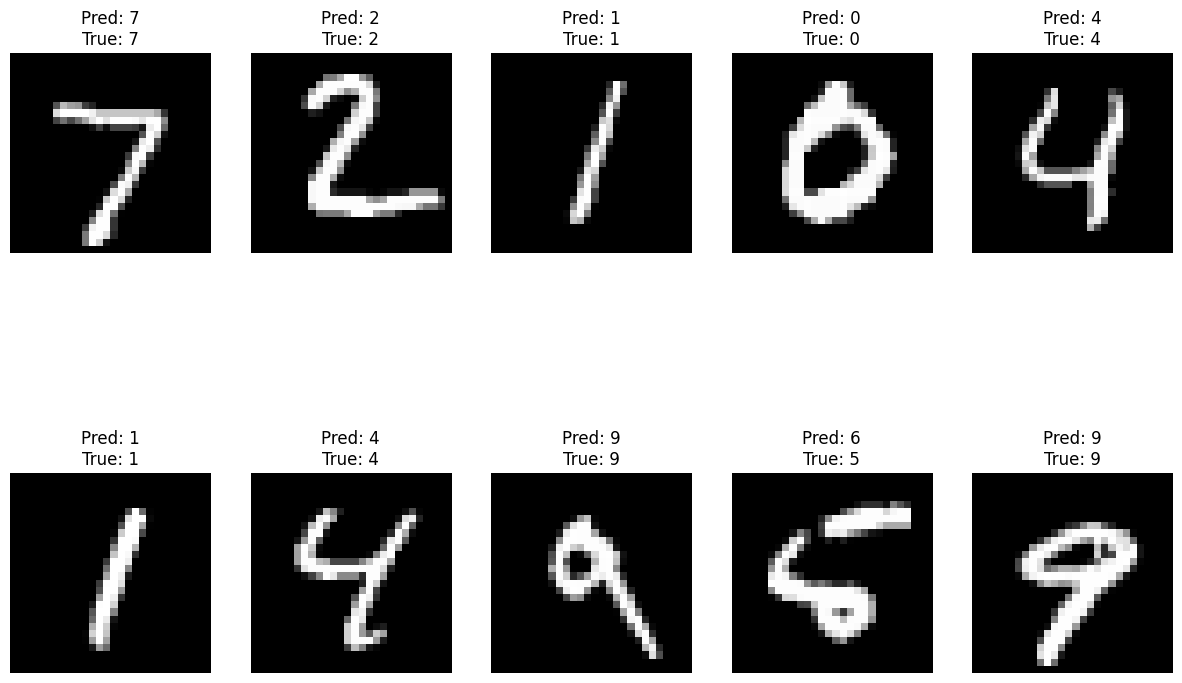

In [10]:
import matplotlib.pyplot as plt

# Predict using the global model
predictions = global_model.predict(x_test)

# Plot some test images with their predicted labels
num_images_to_plot = 10
plt.figure(figsize=(15, 10))

for i in range(num_images_to_plot):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Pred: {np.argmax(predictions[i])}\nTrue: {y_test[i]}")
    plt.axis('off')

plt.show()
